<a href="https://colab.research.google.com/github/JunukCha/NEW-YOLO-MASK/blob/main/new_mask_yolov3_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사본 복사해서 사용하기

# 런타임 유형 GPU로 설정 후 시작바랍니다.

# PPT 자료
https://docs.google.com/presentation/d/1kdve86Nc0JVkvsqMJu4ktItNR8Xzw4mblxKSmBpwKaA/edit?usp=sharing

# 필요한 파일 업로드

In [ ]:
# from google.colab import files

In [ ]:
# files.upload()

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# Code
!wget -c https://download1507.mediafire.com/042555oxh6kgqlwRPKwbrosnSc_nUt_UT4gUH544c4Z4UAMcB_ymi2yFerMT2f3uFgNQW2j7c5ZhpLsJ9I2Tb3yC6eN9trd8FI7hJFAMkmmXoRFRd7Me2NvrKNqiljKG8WGhBAj165ywJ8W4CPuGV6FHmKgkJ3-fjobghTRzNA/1iy4yevwv393xd1/code_file.zip

In [ ]:
# Dataset
!wget -c https://download1594.mediafire.com/s3ox5myvaaxgfCfCk0c7GAlXlI-mHEU0AZiI2Qpr6bdmS8u_-8CEBYdPR4bdDFA_Y3WMRgBBOjKHEbYydXGRszPkKFMYpLq59qbRo-XdiA6CjDXaG0ZpwtIH3cm1r7tqBSujmLbsW80o_XbDnlH9Ur8ErRgMQLfQHZTikoAXNA/wj3z625fjozxqgh/dataset.zip

In [ ]:
# Checkpoints
!wget -c https://download938.mediafire.com/xbwzxafr23zg_UxsDGEdFDTITdcj17c-LooB-GjBJa0XULd6GSMhhyrvFZNXGRPNlky7rgUZ5hsVzFAjhBZ1PooYCiMVn2XOs3521MZdrvWf1jqoL4Szaivavd5aW-qZ0i8RhcsCdyuXctTAISOjoTSOaeiDzNZ74KgngKwAow/oxj1xlk5stnxkdw/checkpoints.zip

In [ ]:
# zip 압축 풀기
!unzip code_file.zip
!unzip dataset.zip
!unzip checkpoints.zip

# !unzip small_dataset.zip

In [ ]:

!wget -c https://pjreddie.com/media/files/yolov3.weights

In [ ]:
!mkdir weights # weight라는 폴더를 생성
!mv yolov3.weights weights # yolov3.weight 파일을 weights 폴더로 이동

# 패키지 설치 및 드라이브 마운트

In [ ]:
!pip install pillow
!pip install tqdm
!pip install terminaltables

## pillow

In [ ]:
from PIL import Image

In [ ]:
image = Image.open("testing/input/images/image2.jpg")

In [ ]:
image

## tqdm

In [ ]:
for i in range(10000):
    for j in range(10000):
        pass

In [ ]:
import tqdm
for i in tqdm.tqdm(range(10000)):
    for j in range(10000):
        pass

## terminaltables


In [ ]:
from terminaltables import AsciiTable

In [ ]:
ap_table = [["Index", "Class name", "AP"]]
ap_table += [[0, "Mask", "0.8124"]]
ap_table += [[1, "No mask", "0.7259"]]
print(ap_table)

In [ ]:
print(AsciiTable(ap_table).table)

패키지 설치 시 `RESTART RUNTIME` 버튼이 나온다면 한 번 RESTART 시켜주고 다시 실행한다.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [ ]:
# import os
# os.chdir('/content/gdrive/My Drive/novatus/mask-detection-yolov3')
# os.listdir()

# Training

## Package import

In [ ]:
from __future__ import division

from models import Darknet
from utils.utils import load_classes, weights_init_normal
from utils.datasets import ListDataset
from utils.parse_config import parse_data_config
from validate import evaluate

from terminaltables import AsciiTable

import os
import time
import argparse
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

import warnings
import easydict
warnings.filterwarnings("ignore", category=UserWarning)

# from utils.logger import *

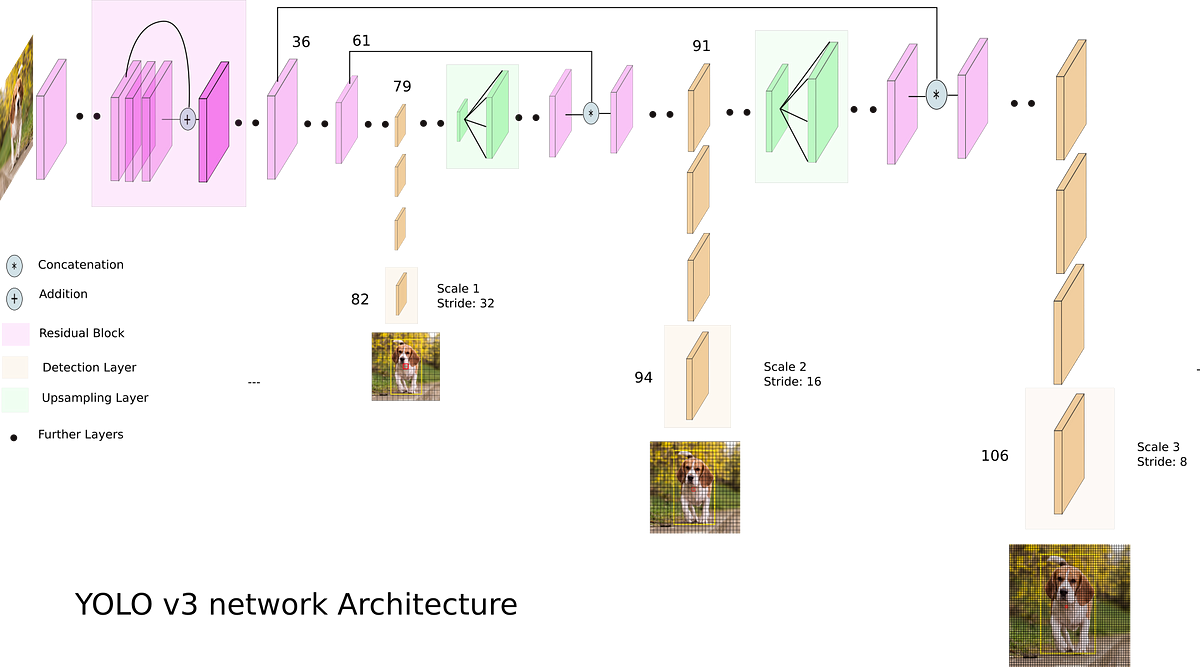

## 2D convolution

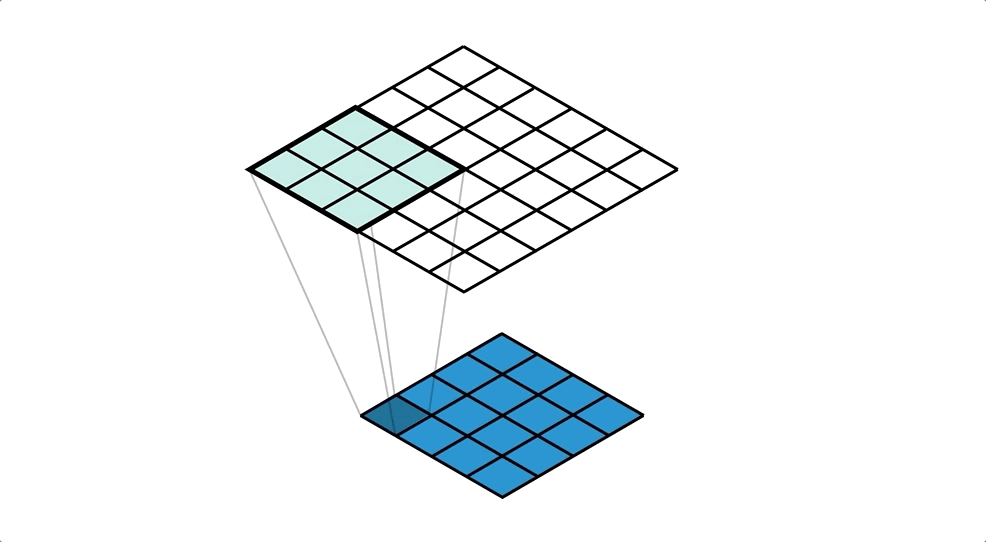

## Residual

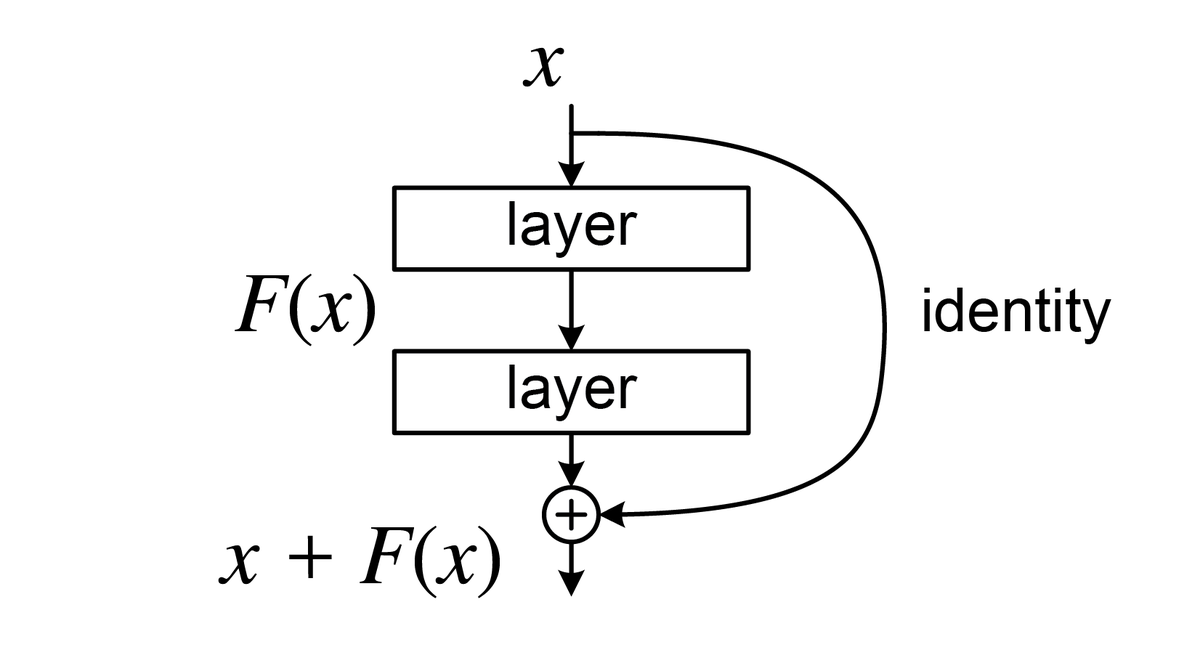

## Zero Padding

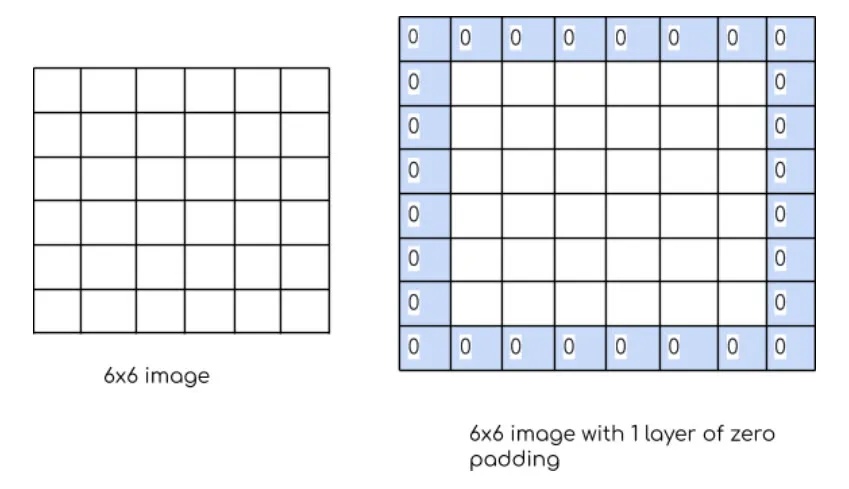

## Training Option Setting
Training Option을 정해준다. 필요한 몇 가지 옵션을 설명하면, epoch은 Training 데이터셋을 몇 번 반복해서 학습할 것인가를 말하며 batch_size는 한 번에 학습할 이미지의 갯수이다. pretrained_weights는 기학습된 모델의 weights 경로이며, checkpoint_interval은 몇 epoch 마다 학습한 모델을 저장할 것인지를 말하며, evaluation_interval은 몇 epoch 마다 모델을 validation set으로 평가할 것인지를 말한다.

이번 실습에서는 시간 상 30 epoch까지 학습하는 training을 진행하려고 한다.

In [ ]:
opt = easydict.EasyDict({
    'epochs': 1,
    'batch_size': 16,
    'gradient_accumulations': 2,
    'model_def': "config/yolov3_mask.cfg",
    'data_config': "config/mask_dataset.data",
    'pretrained_weights': "weights/yolov3.weights",  # weights/yolov3.weights, checkpoints/yolov3_ckpt_35.pth
    "n_cpu": 8,
    'img_size': 416,
    'checkpoint_interval': 10,
    'evaluation_interval': 5,
    'compute_map': True,
    'multiscale_training': True
})
print(opt)
# logger = Logger("logs")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gpu를 사용가능하면 device에 cuda를 저장한다.

os.makedirs("checkpoints", exist_ok=True)
# checkpoints 폴더를 생성

In [ ]:
device

## 데이터와 모델 로딩

In [ ]:
# 데이터셋의 경로와 클래스의 이름 등을 가져온다.
data_config = parse_data_config(opt.data_config)

In [ ]:
data_config

In [ ]:
# data_config["train"] = 'data/small_mask_dataset_train.txt'
# data_config["valid"] = 'data/small_mask_dataset_validate.txt'
# data_config

In [ ]:
# 데이터셋의 경로와 클래스의 이름 등을 가져온다.
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

# dataset의 경로를 통해 ListDataset(dataset을 상속받은 class) 인스턴스를 만들고 이를 쉽게 가져올 수 있는 dataloader를 만든다.
dataset = ListDataset(train_path, augment=True, multiscale=opt.multiscale_training)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
    pin_memory=True,
    collate_fn=dataset.collate_fn,
)

# model을 정해준다. model 폴더에서 Darknet class 내에 yolov3 모델이 저장되어 있다. 모델에 관한 자세한 사항은 Darknet을 참고하자.
model = Darknet(opt.model_def).to(device)
model.apply(weights_init_normal)

# pretrained_weights를 load한다.
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)

In [ ]:
image = Image.open("dataset/train/0_0001.jpg")
image

In [ ]:
import cv2
import numpy as np

In [ ]:
bbox_data = np.loadtxt("dataset/train/0_0001.txt") # 클래스, 중앙 x, 중앙 y, 가로, 세로
bbox_data

In [ ]:
h, w = image.size
x1 = w*(bbox_data[1] - bbox_data[3] / 2)
y1 = h*(bbox_data[2] - bbox_data[4] / 2)
x2 = w*(bbox_data[1] + bbox_data[3] / 2)
y2 = h*(bbox_data[2] + bbox_data[4] / 2)
x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
color = (255, 0, 0)
new_image = cv2.rectangle(np.array(image), (x1, y1), (x2, y2), color, 3)
Image.fromarray(new_image)

In [ ]:
image = Image.open("dataset/train/1_0011.jpg")
image

In [ ]:
bbox_data = np.loadtxt("dataset/train/1_0011.txt") # 클래스, 중앙 x, 중앙 y, 가로, 세로
bbox_data

In [ ]:
h, w = image.size
x1 = w*(bbox_data[1] - bbox_data[3] / 2)
y1 = h*(bbox_data[2] - bbox_data[4] / 2)
x2 = w*(bbox_data[1] + bbox_data[3] / 2)
y2 = h*(bbox_data[2] + bbox_data[4] / 2)
x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
color = (255, 0, 0)
new_image = cv2.rectangle(np.array(image), (x1, y1), (x2, y2), color, 3)
Image.fromarray(new_image)

## Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters()) # Adam optimizer를 사용하며 model의 parameter를 인자로 넣어준다.

# to get mAP
to_get_mAP = None

for epoch in range(opt.epochs): # 미리 설정한 epoch 만큼 반복
    model.train()
    start_time = time.time()

    pbar = tqdm(dataloader)
    for batch_i, (_, imgs, targets) in enumerate(pbar): # dataloader 에서 batch_size 만큼씩 학습.
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets) # model에서 부터 loss 계산
        loss.backward() # loss에 대한 gradient 계산

        if batches_done % opt.gradient_accumulations:
            optimizer.step() # 학습 진행
            optimizer.zero_grad() # gradient를 0으로 만든다.


        log_str = "---- [Epoch %d/%d, Batch %d/%d] ----" % (epoch, opt.epochs, batch_i, len(dataloader))
        log_str += f"Total loss {loss.item():.4f} "
        log_str += f" {time.time()-start_time:.0f}"
        print(log_str)


        model.seen += imgs.size(0)

    if epoch % opt.evaluation_interval==0 or epoch==opt.epochs: # validation set에 대해 mAP 성능평가
        try:
            print("\n---- Evaluating Model ----")
            # Evaluate the model on the validation set
            precision, recall, AP, f1, ap_class = evaluate(
                model,
                path=valid_path,
                iou_thres=0.5,
                conf_thres=0.5,
                nms_thres=0.5,
                img_size=opt.img_size,
                batch_size=4,
            )
            evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
            # logger.list_of_scalars_summary(evaluation_metrics, epoch)

            # Print class APs and mAP
            ap_table = [["Index", "Class name", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
            print(f"---- mAP {AP.mean()}")
            to_get_mAP = AP.mean()
        except:
            to_get_mAP = 999999999999

    if epoch % opt.checkpoint_interval == 0: # checkpoint_interval 마다 model weight 저장.
        torch.save(model.state_dict(), "checkpoints/yolov3_ckpt_{0}.pth".format(epoch))

# Memory 에러 방지를 위한 재시작
## 런타임 -> 런타임 다시 시작

# fine-tuning, 1 epoch 후 image_detect.py 실행

In [ ]:
!python image_detect.py --weights_path checkpoints/yolov3_ckpt_0.pth

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
output_path = './testing/output/images'
for img in os.listdir(output_path):
    img_raw = cv2.imread(os.path.join(output_path, img))
    img_raw = cv2.resize(img_raw, (480, 270))
    cv2_imshow(img_raw)

# fine-tuning, 35 epoch 후 image_detect.py 실행

In [ ]:
!python image_detect.py --weights_path checkpoints/yolov3_ckpt_35.pth

In [ ]:
output_path = './testing/output/images'
for img in os.listdir(output_path):
    img_raw = cv2.imread(os.path.join(output_path, img))
    img_raw = cv2.resize(img_raw, (480, 270))
    cv2_imshow(img_raw)

# WebCam으로 동영상 녹화 후 detecting 하기

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='./testing/input/videos/video.mp4'):

  # This function uses the take_photo() function provided by the Colab team as a
  # starting point, along with a bunch of stuff from Stack overflow, and some sample code
  # from: https://developer.mozilla.org/enUS/docs/Web/API/MediaStream_Recording_API

  js = Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))
  return filename

In [ ]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode

video_width = 300

video_path = record_video()
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""""")

# MASK Detecting

In [ ]:
from __future__ import division

from models import Darknet
from utils.utils import load_classes, non_max_suppression_output
from google.colab.patches import cv2_imshow
import argparse

import time
import cv2
import os
import torch
import numpy as np
from torch.autograd import Variable
import easydict

if __name__ == "__main__":

    opt = easydict.EasyDict({
    'input_file_path': "./testing/input/videos/video.mp4",
    'model_def': "config/yolov3_mask.cfg",
    'weights_path': "checkpoints/yolov3_ckpt_35.pth",
    'class_path': "data/mask_dataset.names",
    'conf_thres': 0.9,
    'nms_thres': 0.4,
    'frame_size': 416,
    'save_video': True,
    'output_path': "./testing/output/videos"
    })
    print(opt)

    # Output directory
    os.makedirs(opt.output_path, exist_ok=True)

    # checking for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set up model
    model = Darknet(opt.model_def, img_size=opt.frame_size).to(device)

    # loading weights
    if opt.weights_path.endswith(".weights"):
        model.load_darknet_weights(opt.weights_path)  # Load weights
    else:
        model.load_state_dict(torch.load(opt.weights_path))  # Load checkpoints

    # Set in evaluation mode
    model.eval()

    # Extracts class labels from file
    classes = load_classes(opt.class_path)

    # ckecking for GPU for Tensor
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    # camara capture
    cap = cv2.VideoCapture(opt.input_file_path)
    assert cap.isOpened(), 'Cannot capture source'

    # Video feed dimensions
    _, frame = cap.read()
    v_height, v_width = frame.shape[:2]

    # print(v_height,v_width)

    # Output saving
    if(opt.save_video):
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')

        filename = opt.input_file_path.split("/")[-1]
        filepath = os.path.join(opt.output_path,filename)

        #fps = cap.get(cv2.CAP_PROP_FPS)
        out = cv2.VideoWriter(filepath, fourcc, 25, (v_width, v_height))

    print("\nPerforming object detection:")

    # For a black image
    x = y = v_height if v_height > v_width else v_width

    # Putting original image into black image
    start_new_i_height = int((y - v_height) / 2)
    start_new_i_width = int((x - v_width) / 2)

    # For accommodate results in original frame
    mul_constant = x / opt.frame_size
    # print(mul_constant)

    # for text in output
    t_size = cv2.getTextSize(" ", cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]

    frames = fps = 0
    start = time.time()

    while _:

        # frame extraction => resizing => [BGR -> RGB] => [[0...255] -> [0...1]] => [[3, 416, 416] -> [416, 416, 3]]
        #                       => [[416, 416, 3] => [416, 416, 3, 1]] => [np_array -> tensor] => [tensor -> variable]

        # frame extraction
        _, org_frame = cap.read()
        # resizing to [416 x 416]
        if not _:
          break

        # Black image
        frame = np.zeros((x, y, 3), np.uint8)

        frame[start_new_i_height: (start_new_i_height + v_height),start_new_i_width: (start_new_i_width + v_width)] = org_frame

        # resizing to [416x 416]
        frame = cv2.resize(frame, (opt.frame_size, opt.frame_size))
        # [BGR -> RGB]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # [[0...255] -> [0...1]]
        frame = np.asarray(frame) / 255
        # [[3, 416, 416] -> [416, 416, 3]]
        frame = np.transpose(frame, [2, 0, 1])
        # [[416, 416, 3] => [416, 416, 3, 1]]
        frame = np.expand_dims(frame, axis=0)
        # [np_array -> tensor]
        frame = torch.Tensor(frame)

        # plt.imshow(frame[0].permute(1,2,0))
        # plt.show()

        # [tensor -> variable]
        frame = Variable(frame.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(frame)
        detections = non_max_suppression_output(detections, opt.conf_thres, opt.nms_thres)

        # For each detection in detections
        detection = detections[0]
        if detection is not None:

            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:

                # Accommodate bounding box in original frame
                x1 = int(x1 * mul_constant - start_new_i_width)
                y1 = int(y1 * mul_constant - start_new_i_height)
                x2 = int(x2 * mul_constant - start_new_i_width)
                y2 = int(y2 * mul_constant - start_new_i_height)

                # Bounding box making and setting Bounding box title
                if (int(cls_pred) == 0):
                    # WITH_MASK
                    cv2.rectangle(org_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                else:
                    # WITHOUT_MASK
                    cv2.rectangle(org_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

                cv2.putText(org_frame, classes[int(cls_pred)] + ": %.2f" % conf, (x1, y1 + t_size[1] + 4),
                            cv2.FONT_HERSHEY_PLAIN, 1,
                            [225, 255, 255], 2)


        # FPS PRINTING
        # cv2.rectangle(org_frame, (0, 0), (175, 20), (0, 0, 0), -1)
        # cv2.putText(org_frame,"FPS : %3.2f" % (fps), (0, t_size[1] + 4),
        #             cv2.FONT_HERSHEY_PLAIN, 1,
        #             [255, 255, 255], 1)

        frames += 1
        fps = frames / (time.time() - start)

        # cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
        # cv2.setWindowProperty('frame', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

        if (opt.save_video):
            out.write(org_frame)

        #cv2_imshow(org_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    if (opt.save_video):
        out.release()

    cap.release()
    cv2.destroyAllWindows()

# YOLOv8
- https://docs.ultralytics.com/
- YOLOv3에 비해 성능이 좋고, 개체 감지, 인스턴스 세분화 및 이미지 분류 모델을 train하기 위한 통합 프레임워크

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

In [ ]:
import yaml

In [ ]:
data_yaml = {
    "train": "/content/dataset/train",
    "val": "/content/dataset/validate",

    # Classes
    "names": {
        0: "Mask",
        1: "No mask"
    }
}
with open("data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

In [ ]:
results = model.train(data='data.yaml', epochs=5)

In [ ]:
from PIL import Image

In [ ]:
Image.open("/content/runs/detect/train/val_batch0_pred.jpg")

In [ ]:
Image.open("/content/runs/detect/train/val_batch1_pred.jpg")

In [ ]:
Image.open("/content/runs/detect/train/val_batch2_pred.jpg")

# Testing

In [ ]:
!yolo predict model=/content/runs/detect/train/weights/best.pt source='/content/testing/input/images/*.jpg'

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
output_path = '/content/runs/detect/predict'
for img in os.listdir(output_path):
    img_raw = cv2.imread(os.path.join(output_path, img))
    img_raw = cv2.resize(img_raw, (480, 270))
    cv2_imshow(img_raw)